# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problem is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-86c6379b-879a-ba26-d7de-ce34e5e56af6)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

# Import a series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-05-20 12:10:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-20 12:10:33 (62.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text datset

The dataset we're going to be using Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-05-20 12:10:37--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.003s  

2025-05-20 12:10:37 (168 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5) #create random indexes not higher than the total number of examples
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Test:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Test:
Check this out! Lightning reshapes rocks at the atomic level http://t.co/l1gH8064YV #scichat #science

---

Target: 1 (real disaster)
Test:
No #news of #hostages in #Libya

http://t.co/k9FBtcCU58

#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/XYj0rPsAI2

---

Target: 1 (real disaster)
Test:
PRAY! For EAST COAST FOREST FIRES! PRAY! That they be put out. PRAY! For RAIN!

---

Target: 0 (not real disaster)
Test:
???????????? @MikeParrActor absolutely devastated what an actor. Will miss #RossBarton every girls loves a bad boy

---

Target: 1 (real disaster)
Test:
Some poor sods arriving in Amman during yesterday's dust storm were diverted to Ben Gurion airport: http://t.co/jkpjpcH9i6

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences,train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1,
                                                                           random_state=42)

In [13]:
# Check the lengths
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the firt 10 esamples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - creature a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learn)

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [17]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # How many wordsin the in the vocabulary (automatically ad <00v>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #Create groups of n-words
                                    output_mode = "int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=False)

In [18]:
# Find the average number of tokens (words) in the traininf tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
# Setup text Vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from pur tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [20]:
# Fit the text vectorizer tp the training text
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 @SexyDragonMagic I've come to the realization that I just don't have the attention span for mass battle games. Both painting and playing.        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8623,  276,  220,    5,    2, 9311,   16,    8,   29,   63,   24,
           2, 1899, 8252,   10]])>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # Get all the unique words in the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the leats common words

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 leats common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
5 leats common words: [np.str_('pages'), np.str_('paeds'), np.str_('pads'), np.str_('padres'), np.str_('paddytomlinson1')]


### Creating an Embedding using an Embedding layer

To maje our embadding, we're going to use TensorFlow's embedding layer.

The parameters we care most about for our embedding layer:
* input_dim: the size of pur vocabulary
* output_dim = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* input_length = length of the sequences being passed to the embedding layer

In [24]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, #input shape
                             output_dim = 128, #output shape
                             embeddings_initializer =  "uniform",
                             input_length = max_length) # how long is each input
embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding, built=False>

In [25]:
# Get a random sentence from the training set

random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
       \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @XHNews We need these plants in the pacific during the cyclone seasons it would help       

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00305363,  0.02431395,  0.04100997, ...,  0.0202692 ,
          0.01812733,  0.03016609],
        [ 0.03329769, -0.04289904, -0.03771073, ..., -0.04142058,
         -0.02893551, -0.03178262],
        [ 0.00066506, -0.02300893,  0.02257719, ...,  0.03788808,
          0.02921105, -0.04232118],
        ...,
        [-0.00037903, -0.0159459 , -0.01593318, ...,  0.02806233,
         -0.03121899,  0.02609572],
        [-0.02954022,  0.02991934,  0.01184314, ...,  0.01636295,
         -0.04561553, -0.04733631],
        [-0.04258264,  0.01625625,  0.03721635, ...,  0.00242899,
         -0.01695385,  0.01446677]]], dtype=float32)>

In [26]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00305363,  0.02431395,  0.04100997,  0.04459541,  0.01019062,
         0.04901252, -0.00429321, -0.03564372, -0.0140955 ,  0.00714188,
         0.00958172, -0.0129158 , -0.03042982,  0.01420918,  0.02141238,
        -0.0301981 ,  0.0099849 , -0.03335603, -0.02371287,  0.01988227,
         0.04181297, -0.0039345 , -0.03500471,  0.03116322, -0.01046616,
         0.01437492, -0.01673756,  0.01797657,  0.02970401, -0.01819728,
        -0.02664311, -0.00697899, -0.02070012, -0.0330325 ,  0.00869199,
         0.01467781, -0.03586911, -0.03265889, -0.00294665, -0.03582994,
        -0.0488308 ,  0.02930656,  0.00582327, -0.04120636,  0.02214979,
         0.02693463, -0.00248555,  0.04632417,  0.00587628,  0.03223697,
        -0.0066561 ,  0.02754563,  0.00153446, -0.01184054,  0.01288588,
         0.02389571,  0.03533418, -0.0097662 , -0.00132899,  0.04554432,
         0.03610864, -0.04455639, -0.03917589, -0.01791564,  0.03810289,
  

## Modeling a text dataset (running a series of experiments)

Now we've a got wat to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/machine_learning_map.html
* Model 1: Feed-forward neural-network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning)
* Model 7: Same as model 6with 10% of training data

How are we going to approach all of these?

Use the standard steps in modlling with tensorflow:
* Create model
* Compile model
* Fit model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using TF-IDF formula to convert our words to numbers.

> Note: It's common practice to use non-DL algorithms as baseline because of their speed and then later using DL to see if you can improve upon them.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [28]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text

                  ])
# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [31]:
train_labels[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

### Crrating an evaluation funtion for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [32]:
# Funtion to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  """
  Calculayte model accuracy, precision, recall and f1 score of a binary classification model.

  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true,y_pred)*100
  # Calculate model precision, recall and f1-score using weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [33]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [34]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save Tensorboar logs
SAVE_DIR = "model_logs"


In [35]:
# Build model with functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an e,bedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1,activation="sigmoid")(x) # create an output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")

In [36]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["Accuracy"])

In [38]:
# Fit the model
import numpy as np
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                      experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20250520-121041
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Accuracy: 0.6417 - loss: 0.6496 - val_Accuracy: 0.7480 - val_loss: 0.5402
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.8100 - loss: 0.4607 - val_Accuracy: 0.7822 - val_loss: 0.4701
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.8648 - loss: 0.3475 - val_Accuracy: 0.7848 - val_loss: 0.4559
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.8870 - loss: 0.2945 - val_Accuracy: 0.7848 - val_loss: 0.4628
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.9136 - loss: 0.2394 - val_Accuracy: 0.7782 - val_loss: 0.4804


In [39]:
# Check the results
model_1.evaluate(val_sentences,val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.7672 - loss: 0.5134


[0.4804325997829437, 0.778215229511261]

In [40]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(762, 1)

In [41]:
# Look a single predictions
model_1_pred_probs[0]

array([0.40053293], dtype=float32)

In [42]:
# Convert model predictions probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [43]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 77.82152230971128,
 'precision': 0.7814103276314137,
 'recall': 0.7782152230971129,
 'f1': 0.7756075024838145}

In [44]:
# Looks like our baseline is out performing our first deep learning model...
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000,
 ['',
  '[UNK]',
  np.str_('the'),
  np.str_('a'),
  np.str_('in'),
  np.str_('to'),
  np.str_('of'),
  np.str_('and'),
  np.str_('i'),
  np.str_('is')])

In [46]:
# model 1 summary
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [47]:
# get the weight matrix of the embedding layer
# (these are the numerical representation of each token in our training data, which have been learned for 5 epochs)

embed_weights = model_1.get_layer("embedding").get_weights()[0]
(embed_weights.shape)

(10000, 128)

In [48]:
len(embed_weights)

10000

In [49]:
embed_weights[:2].shape

(2, 128)

In [50]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a reccurent neural network is to use the representation of a previous input to aid the representation of a later input.
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
*[ The Unreasonable Effectiveness of Recurrent Neural Networks by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) - demonstrates the power of RNN's with examples generating various sequences.
* [Understanding LSTMs by Chris Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.

### Model 2: LSTM

LSTM = Long Short Term Memory

Our structure of a RNN typically looks like this:

Input (test) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)

In [51]:
# Create a LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64,return_sequences=True)(x) # When you are stacking RNN cells together, you need to set return_sequences = True
#print(x.shape)
x = layers.LSTM(64,)(x)
#print(x.shape)
x = layers.Dense(64,activation="relu")(x)
#print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")


In [52]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,333,633 (5.09 MB)

 Trainable params: 1,333,633 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20250520-121052
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9094 - loss: 0.2993 - val_accuracy: 0.7808 - val_loss: 0.5955
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9479 - loss: 0.1463 - val_accuracy: 0.7887 - val_loss: 0.6537
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9546 - loss: 0.1184 - val_accuracy: 0.7913 - val_loss: 0.6543
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9622 - loss: 0.1133 - val_accuracy: 0.7743 - val_loss: 0.8311
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9678 - loss: 0.0813 - val_accuracy: 0.7690 - val_loss: 1.0020


In [55]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


array([[1.2453263e-01],
       [9.2747307e-01],
       [9.9996424e-01],
       [1.2995586e-01],
       [7.7697239e-04],
       [9.9982721e-01],
       [9.8649526e-01],
       [9.9998784e-01],
       [9.9996257e-01],
       [5.5508298e-01]], dtype=float32)

In [56]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [57]:
# Calculaye model 2 results
model_2_results = calculate_results(y_true=val_labels,y_pred=model_2_preds)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7687238913925833,
 'recall': 0.7690288713910761,
 'f1': 0.7687911410094547}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [59]:
# Build a RNN using the GRU cell
from tensorflow.keras import layers
input = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64,return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
#x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [60]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20250520-121109
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8889 - loss: 0.2647 - val_accuracy: 0.7822 - val_loss: 0.6975
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9679 - loss: 0.0810 - val_accuracy: 0.7690 - val_loss: 0.9018
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9717 - loss: 0.0708 - val_accuracy: 0.7690 - val_loss: 0.8779
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9789 - loss: 0.0575 - val_accuracy: 0.7703 - val_loss: 1.0027
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9730 - loss: 0.0608 - val_accuracy: 0.7756 - val_loss: 1.0616


In [62]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[3.1352381e-03],
       [8.6950153e-01],
       [9.9981529e-01],
       [6.4268574e-02],
       [2.8750408e-04],
       [9.9931085e-01],
       [7.4027783e-01],
       [9.9994648e-01],
       [9.9984336e-01],
       [7.4257219e-01]], dtype=float32)

In [63]:
# Convert model 3 pred probs to labels
model_3_preds =tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.55905511811024,
 'precision': 0.7772070861555818,
 'recall': 0.7755905511811023,
 'f1': 0.7736182129212565}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidrectional RNN goes from right to left as well as left to right.

In [65]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4_bidirectional")

In [66]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20250520-121123
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9408 - loss: 0.1970 - val_accuracy: 0.7703 - val_loss: 0.8981
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9769 - loss: 0.0518 - val_accuracy: 0.7651 - val_loss: 0.9962
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9786 - loss: 0.0470 - val_accuracy: 0.7664 - val_loss: 1.0095
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9829 - loss: 0.0390 - val_accuracy: 0.7585 - val_loss: 1.0811
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9792 - loss: 0.0437 - val_accuracy: 0.7572 - val_loss: 1.2890


In [69]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


array([[6.1739221e-02],
       [6.5065372e-01],
       [9.9998951e-01],
       [7.4766956e-02],
       [6.4073996e-05],
       [9.9948210e-01],
       [9.8512727e-01],
       [9.9999225e-01],
       [9.9998498e-01],
       [9.8018128e-01]], dtype=float32)

In [70]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.7217847769029,
 'precision': 0.7567817252856622,
 'recall': 0.7572178477690289,
 'f1': 0.756704019080563}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height * width) ... however, out text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

> Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)

### Model 5: Conv1D

In [72]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 woords at a time)
                        strides=1, #default
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape,max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [73]:
# Build a 1D convolutional neural network
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Conv1D(filters=64,kernel_size=5,padding="valid",activation="relu")(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs,name="model_5_Conv1D")

(None, 15, 128)
(None, 11, 64)
(None, 64)


In [74]:
# compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences,val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_convolutional")])

Saving TensorBoard log files to: model_logs/model_5_convolutional/20250520-121139
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9346 - loss: 0.1785 - val_accuracy: 0.7717 - val_loss: 0.8978
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9770 - loss: 0.0596 - val_accuracy: 0.7533 - val_loss: 1.0287
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9751 - loss: 0.0600 - val_accuracy: 0.7677 - val_loss: 1.1301
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9847 - loss: 0.0418 - val_accuracy: 0.7585 - val_loss: 1.1518
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9830 - loss: 0.0438 - val_accuracy: 0.7559 - val_loss: 1.1814


In [76]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[4.7678259e-01],
       [7.3983210e-01],
       [9.9990308e-01],
       [7.8290753e-02],
       [1.7154586e-06],
       [9.8984295e-01],
       [9.3555939e-01],
       [9.9998653e-01],
       [9.9999917e-01],
       [9.2350113e-01]], dtype=float32)

In [77]:
# convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'precision': 0.7557293707913207,
 'recall': 0.7559055118110236,
 'f1': 0.7547819586377322}

In [79]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6: TensorFlow Hub Pretrained Sentences Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specially using Tensorflow Hub's Universal Sentence Encoder: "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [80]:
sample_sentence

"There's a flood in my street!"

In [81]:
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
embed_samples = embed([sample_sentence,
                       "when you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [82]:
embed_samples[0].shape

TensorShape([512])

In [83]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape = [],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [84]:
import tf_keras

In [85]:
# Create model using the Sequential API
model_6 = tf_keras.Sequential([
    sentence_encoder_layer,
    tf_keras.layers.Dense(64,activation="relu"),
    tf_keras.layers.Dense(1,activation="sigmoid")
],name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [86]:
from tf_keras import callbacks

In [87]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 6s 13ms/step - loss: 0.5105 - accuracy: 0.7889 - val_loss: 0.4483 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4170 - accuracy: 0.8108 - val_loss: 0.4389 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4026 - accuracy: 0.8225 - val_loss: 0.4369 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3946 - accuracy: 0.8225 - val_loss: 0.4347 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3872 - accuracy: 0.8304 - val_loss: 0.4287 - val_accuracy: 0.8176


In [88]:
# Make predictions with USE TF hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs.shape

24/24 [==============================] - 1s 9ms/step


(762, 1)

In [89]:
# Convert predictions probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8180726407863905,
 'recall': 0.8175853018372703,
 'f1': 0.8167845198250385}

In [91]:
len(train_sentences)

6851

## Model 7: TF Hub Pretrained USe but with 10% of training data

Transfer Learning really helps when you don't have a large dataset.

To see how out model performs on a smaller dataset, let's replicate model_6 except we'll train it on 10% of the data.

In [92]:
## Note: Making datat split like below leads to data leakage (model_7 trained in the 10 percent data out perform model_6 full data)
## DO NOT MAKE DATA SPLIT WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
#train_10_percent.head(),len(train_10_percent)
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["target"].to_list()
#len(train_sentences_10_percent),len(train_labels_10_percent)

> **Note** Be *very* careful when creating training/val/test splits that you do not leak across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust yout gut and go back trrough to find where the error may lie.

In [93]:
# Makinbg a better dataset split (no data leakage)
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]


In [94]:
# Check the number of each labels in the uopdated training dataset updated
pd.Series(np.array(train_labels_10_percent)).value_counts()

,count
0,406
1,279


In [95]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


To recreate a model the same as a previous model you've created you can use the tf.keras.models.clone()

In [96]:
# Let's build a model the same model as model_6
model_7 = tf_keras.models.clone_model(model_6)
model_7._name = "model_7_10_percent_USE"
# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer = tf_keras.optimizers.Adam(),
                metrics = ["accuracy"])
# Get a summary (will be same as model_6)

model_7.summary()



Model: "model_7_10_percent_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [97]:
# Fit the model to the 10% of the training datat subset

model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data = (val_sentences,val_labels))

Epoch 1/5
22/22 [==============================] - 4s 42ms/step - loss: 0.6727 - accuracy: 0.5985 - val_loss: 0.6549 - val_accuracy: 0.6837
Epoch 2/5
22/22 [==============================] - 0s 21ms/step - loss: 0.6082 - accuracy: 0.7985 - val_loss: 0.6012 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5350 - accuracy: 0.8102 - val_loss: 0.5443 - val_accuracy: 0.7795
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4705 - accuracy: 0.8175 - val_loss: 0.5082 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4273 - accuracy: 0.8263 - val_loss: 0.4900 - val_accuracy: 0.7730


In [98]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.24173476],
       [0.610922  ],
       [0.89712083],
       [0.37118012],
       [0.5421705 ],
       [0.6968975 ],
       [0.87662226],
       [0.81720537],
       [0.8591065 ],
       [0.15860823]], dtype=float32)

In [99]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [100]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

In [101]:
model_7_results

{'accuracy': 77.29658792650919,
 'precision': 0.7728481089662449,
 'recall': 0.7729658792650919,
 'f1': 0.7720634753279543}

## Compare the performance of each of our models

In [102]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                  "1_simple_dense":model_1_results,
                                  "2_lstm":model_2_results,
                                  "3_gru":model_3_results,
                                  "4_bidirectional":model_4_results,
                                  "5_conv1d":model_5_results,
                                  "6_tf_hub_use_encoder":model_6_results,
                                  "7_tf_hub_use_encoder_10_percent":model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,77.821522,0.781410,0.778215,0.775608
2_lstm,76.902887,0.768724,0.769029,0.768791
3_gru,77.559055,0.777207,0.775591,0.773618
4_bidirectional,75.721785,0.756782,0.757218,0.756704
5_conv1d,75.590551,0.755729,0.755906,0.754782
6_tf_hub_use_encoder,81.758530,0.818073,0.817585,0.816785
7_tf_hub_use_encoder_10_percent,77.296588,0.772848,0.772966,0.772063


In [103]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.778215,0.781410,0.778215,0.775608
2_lstm,0.769029,0.768724,0.769029,0.768791
3_gru,0.775591,0.777207,0.775591,0.773618
4_bidirectional,0.757218,0.756782,0.757218,0.756704
5_conv1d,0.755906,0.755729,0.755906,0.754782
6_tf_hub_use_encoder,0.817585,0.818073,0.817585,0.816785
7_tf_hub_use_encoder_10_percent,0.772966,0.772848,0.772966,0.772063


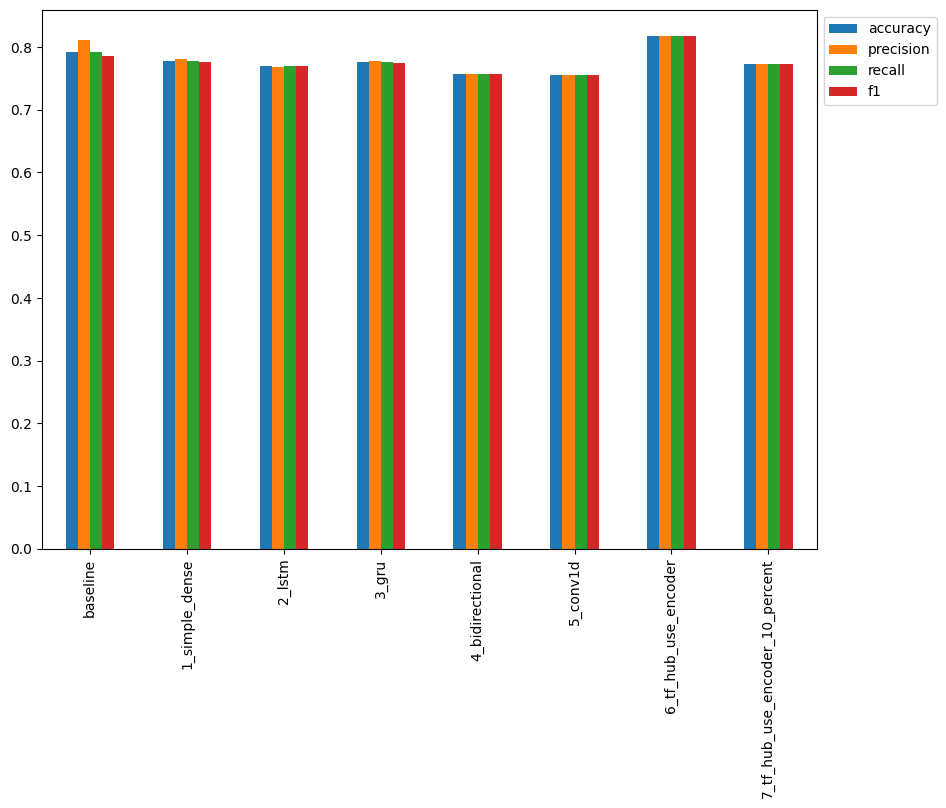

In [104]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

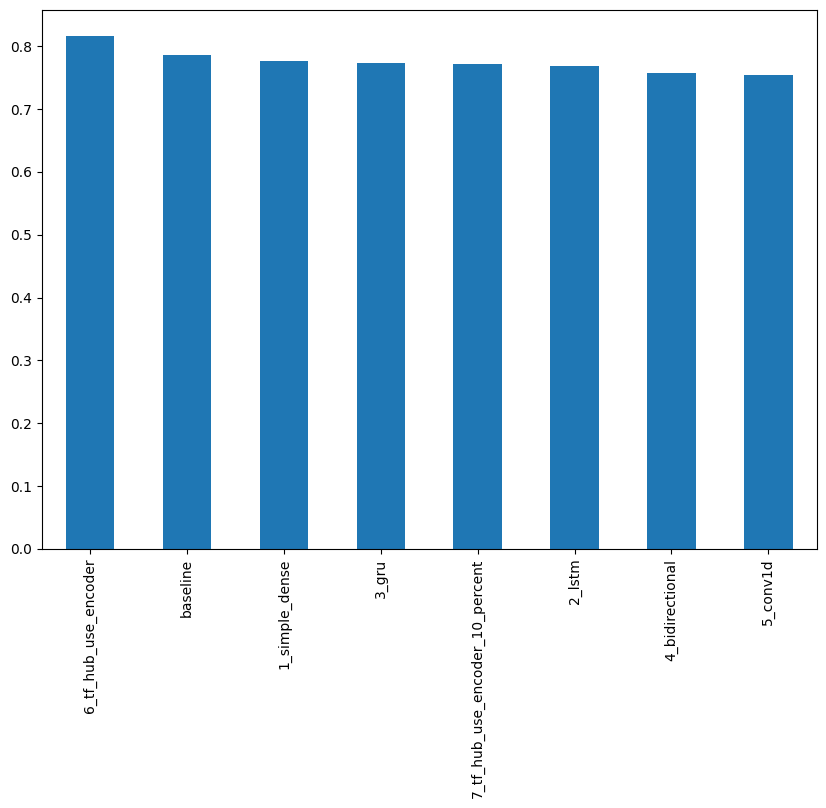

In [105]:
# Sort model results by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

## Saving and loading a trained model

There are two main formats to save a model to in tensorFlow:
1. The HDF5 format
2. The 'SaveModel' formar (this is the default when using TensorFlow)

In [106]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [107]:
# Load model with cuystom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf_keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer":hub.KerasLayer})

In [108]:
# How does our loadeed model perform?
loaded_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4287 - accuracy: 0.8176


[0.42867112159729004, 0.817585289478302]

In [109]:
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8180726407863905,
 'recall': 0.8175853018372703,
 'f1': 0.8167845198250385}

Now let's save to the 'SavedModel' format...

In [110]:
# Save TF Hub Sentence Encoder model to SaveModel format (default)

model_6.save("model_6_saved_model")

In [111]:
# Load in a model from the SavedModel format Legacy code
loaded_model_6_savedmodel_format = tf.keras.layers.TFSMLayer("model_6_saved_model", call_endpoint='serving_default')

> As a legacy code we cannot use the evaluate function, but it is not important for the course, because this is a way not used anymore

## The speed/score tradeoff

In [125]:
# Let's make a function to measure the time of prediction
import time

def pred_timer(model,samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() #get start time
  model.predict(samples)
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # Calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred


In [126]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6,samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 16ms/step


(0.7228644140000142, 0.0009486409632546119)

In [128]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.020084668999970745, 2.635783333329494e-05)

In [129]:
#calculate model 6 results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8180726407863905,
 'recall': 0.8175853018372703,
 'f1': 0.8167845198250385}

Text(0, 0.5, 'F1-score')

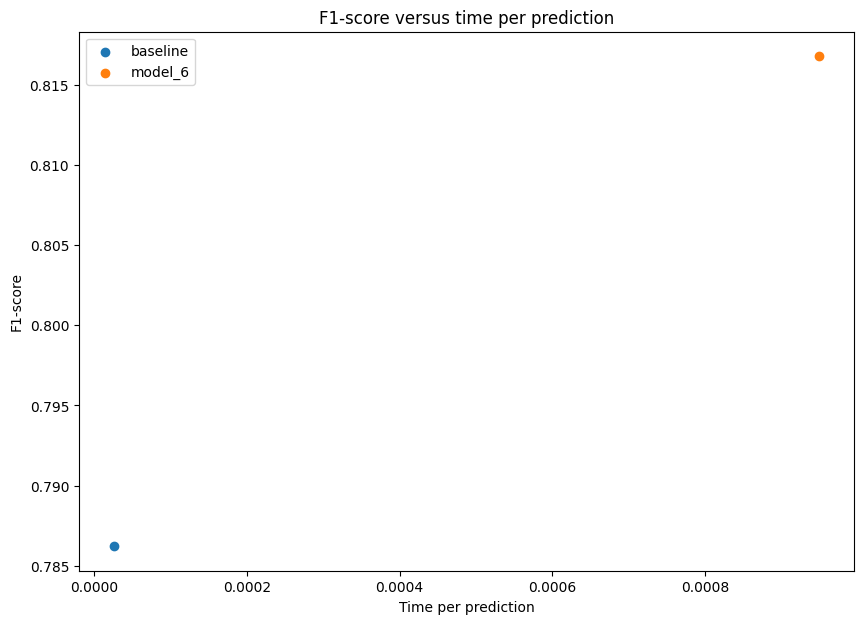

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred,baseline_results["f1"],label="baseline")
plt.scatter(model_6_time_per_pred,model_6_results["f1"],label="model_6")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")